In [1]:
import pandas as pd
from glob import glob
import math
import numpy as np
from skimage import io, morphology, img_as_ubyte, img_as_float, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from scipy import io as sio
from centerline import CenterLine, smooth_mask, iou

### Read centerlines from a .mat file produced by ctFIRE

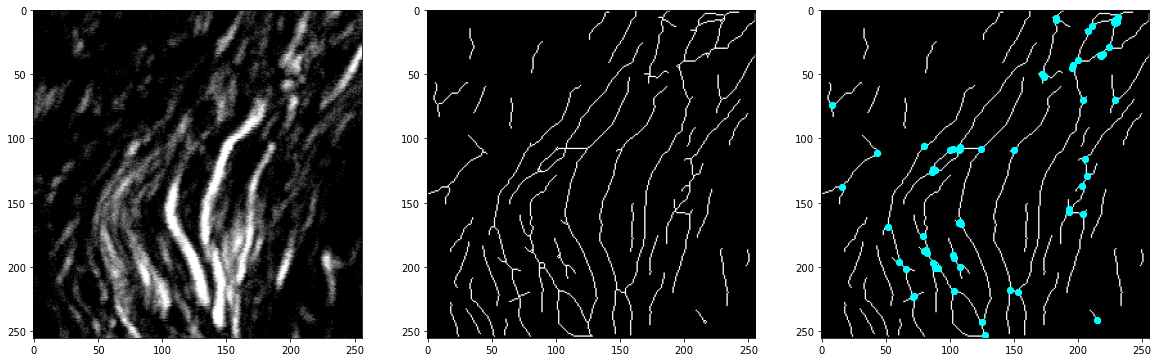

{'cir_mean': -1.4144546600578425, 'cir_var': 0.4933967730955828, 'len_mean': 34.32, 'len_var': 30.43601375563714, 'waviness': 0.34109834393793986, 'intensity': 2679}


In [11]:
mat = sio.loadmat('example_ctFIRE.mat')
mat_data = mat['data']
centerline_mat = CenterLine()
line_dict = centerline_mat.mat_to_lines(mat_data)
centerline_mat = CenterLine(line_dict=line_dict, associate_image=io.imread("example_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_mat.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_mat.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_mat.joint_filter(centerline_mat.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_mat.export_line_dict('example_image_ctFIRE_line_dict.csv')

### compute features from ctFIRE extracted centerline, note that the range of cir_mean is Pi (3.14, 5% error is ~0.15)
centerline_mat.compute_fiber_feats() 
print(dict(list(centerline_mat.feats.items())[:-1]))

### Run ridge detector on a image

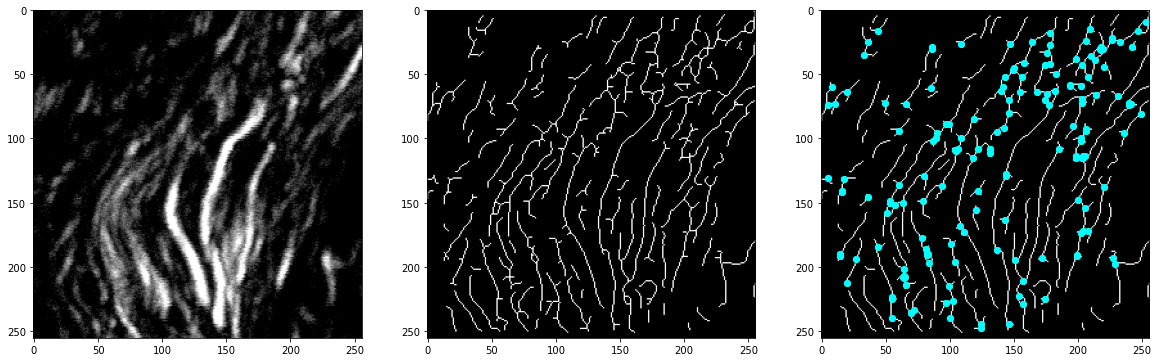

{'cir_mean': -1.4694341510575188, 'cir_var': 0.46677791017472015, 'len_mean': 18.804232804232804, 'len_var': 15.135325477883308, 'waviness': 0.38212495715636136, 'intensity': 3913}


In [12]:
centerline_ridge = CenterLine(associate_image=io.imread("example_input.png"))
line_dict = centerline_ridge.ridge_detector(config_fname="ridge_detector_params.json")
centerline_ridge = CenterLine(line_dict=line_dict, associate_image=io.imread("example_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_ridge.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_ridge.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_ridge.joint_filter(centerline_ridge.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
centerline_ridge.export_line_dict('example_image_ridge_line_dict.csv')
centerline_ridge.compute_fiber_feats() 
print(dict(list(centerline_ridge.feats.items())[:-1]))

### Skeletonize a network output

Draw masks using skeletonization


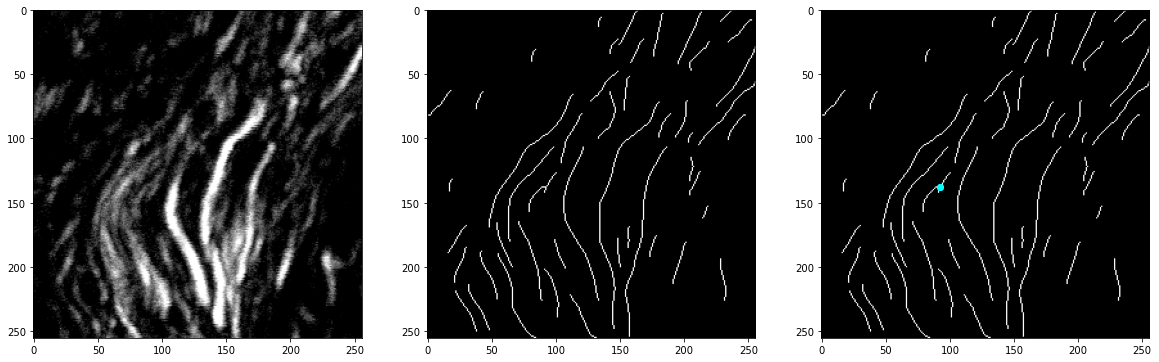

Network results:
{'cir_mean': -1.203951923481333, 'cir_var': 0.2684179136116452, 'len_mean': 37.224489795918366, 'len_var': 34.73530539762422, 'waviness': 0.2982665680236125, 'intensity': 1825}


In [13]:
# vectorization using skimage skeletonization
img = img_as_float( io.imread("example_network-raw.png") )
binary = img > filters.threshold_otsu((img))
centerline_res = CenterLine(associate_image=binary, draw_from_raw=True)
centerline_res = CenterLine(centerline_image=centerline_res.centerline_image, associate_image=io.imread("example_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(dict(list(centerline_res.feats.items())[:-1]))

### Ground truth

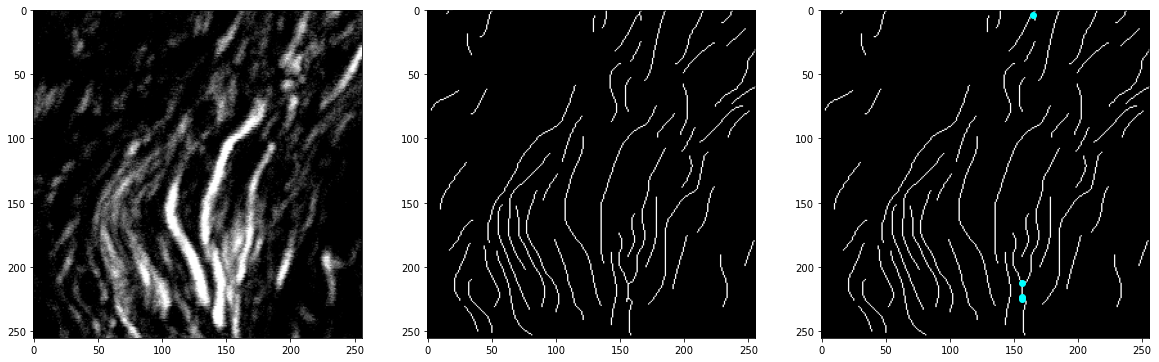

Ground truth:
{'cir_mean': -1.3195425200408986, 'cir_var': 0.3188771778968849, 'len_mean': 45.34615384615385, 'len_var': 32.911235289548515, 'waviness': 0.28158625930238684, 'intensity': 2369}


In [17]:
# Ground truth
centerline = CenterLine(centerline_image=io.imread("example_groundtruth.png"), associate_image=io.imread("example_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Ground truth:')
centerline.compute_fiber_feats()
print(dict(list(centerline.feats.items())[:-1]))

### Check IoU and mask differences

ctFIRE
0.5895486895144079


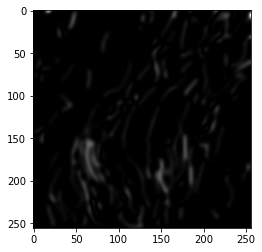

Ridge detector
0.6638691326972721


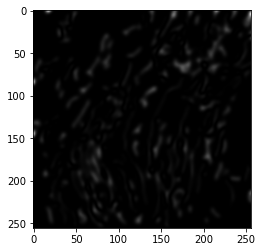

Network
0.7171113401372445


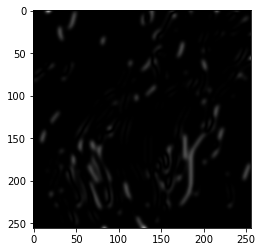

In [21]:
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_mat.centerline_image), soft=True)
print('ctFIRE')
print(ratio)
plt.imshow(U-I, cmap='gray')
plt.show()
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_ridge.centerline_image), soft=True)
print('Ridge detector')
print(ratio)
plt.imshow(U-I, cmap='gray')
plt.show()
ratio, U, I = iou(smooth_mask(centerline.centerline_image), smooth_mask(centerline_res.centerline_image), soft=True)
print('Network')
print(ratio)
plt.imshow(U-I, cmap='gray')
plt.show()

### (Optional) Network output can also be vectorized using ridge detector

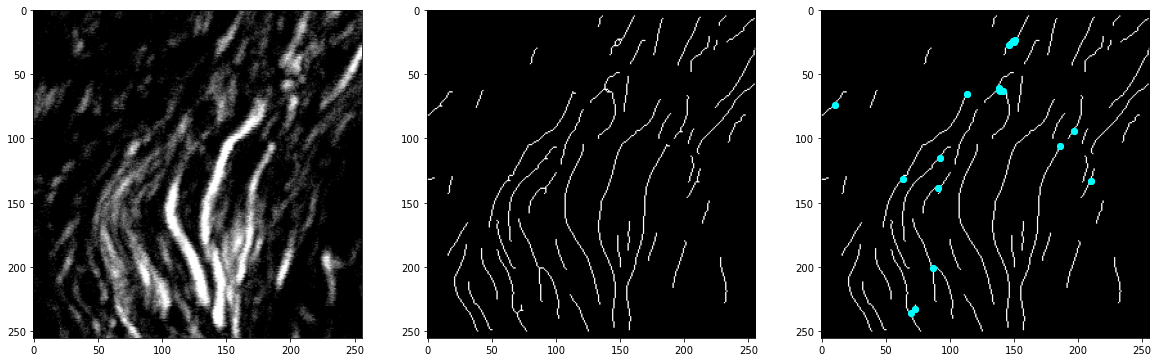

Network results:
{'cir_mean': -1.230385798055068, 'cir_var': 0.29738943978757376, 'len_mean': 34.05263157894737, 'len_var': 32.855569664625705, 'waviness': 0.31528666308199926, 'intensity': 1975}


In [22]:
# vectorization using ridge detector
img = img_as_float( io.imread("example_network-raw.png") )
binary = img > filters.threshold_mean((img))
centerline_res = CenterLine(associate_image=binary)
line_dict = centerline_res.ridge_detector(config_fname="ridge_detector_params.json")
centerline_res = CenterLine(line_dict=line_dict, associate_image=io.imread("example_input.png"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline_res.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline_res.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline_res.joint_filter(centerline_res.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()
print('Network results:')
centerline_res.compute_fiber_feats()
print(dict(list(centerline_res.feats.items())[:-1]))

### Visualize individual fiber extraction results

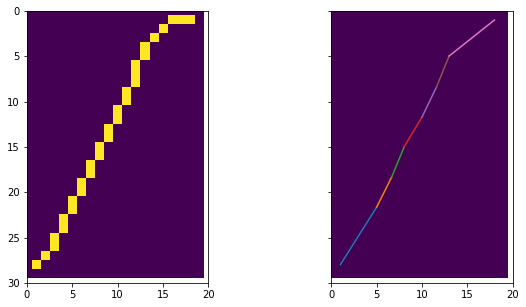

Length: 30.00, Waveiness: 0.3835 



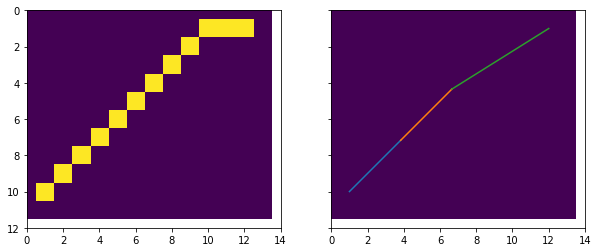

Length: 12.00, Waveiness: 0.1298 



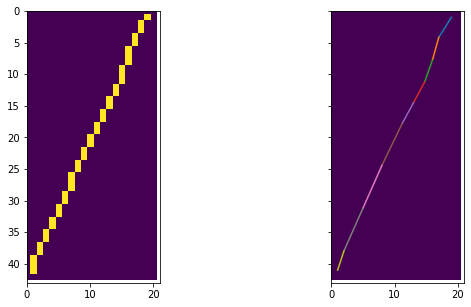

Length: 41.00, Waveiness: 0.3536 



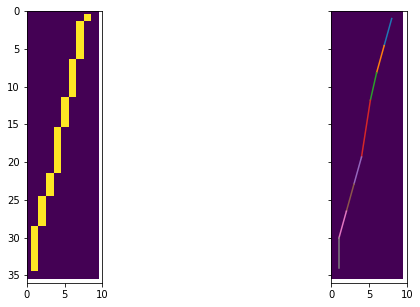

Length: 34.00, Waveiness: 0.2940 



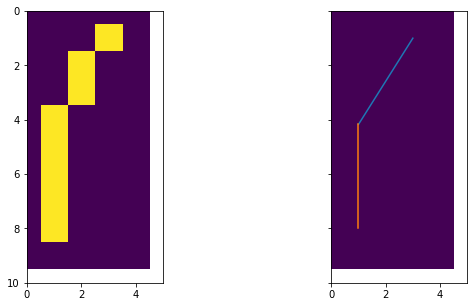

Length: 8.00, Waveiness: 0.2731 



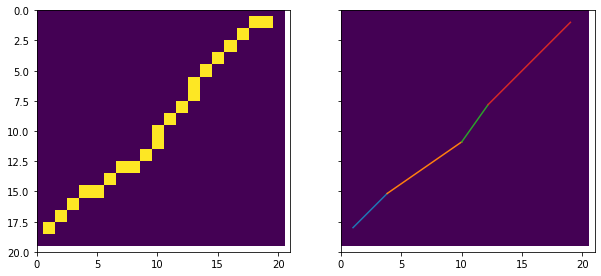

Length: 21.00, Waveiness: 0.2756 



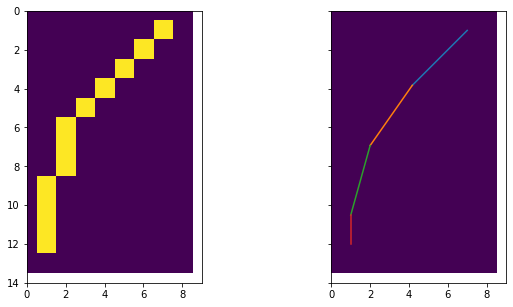

Length: 12.00, Waveiness: 0.2883 



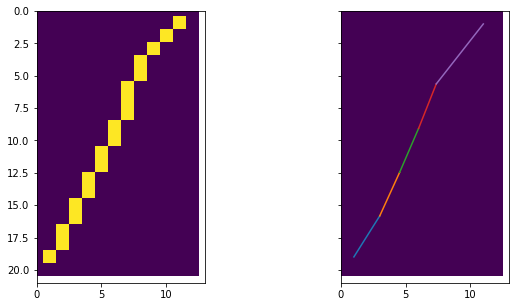

Length: 19.00, Waveiness: 0.3379 



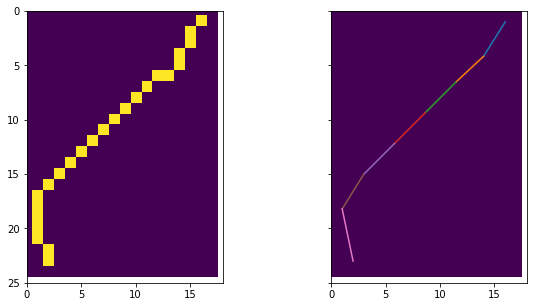

Length: 24.00, Waveiness: 0.2665 



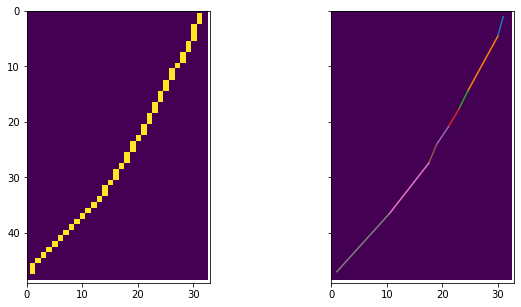

Length: 47.00, Waveiness: 0.3007 



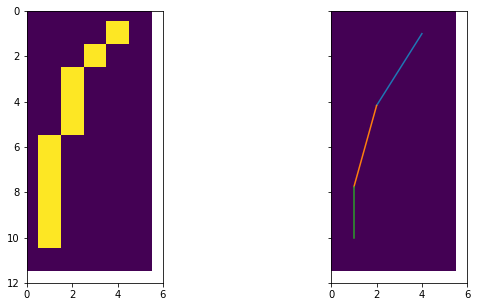

Length: 10.00, Waveiness: 0.3086 



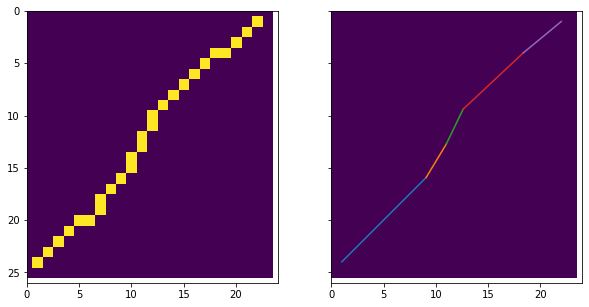

Length: 26.00, Waveiness: 0.2524 



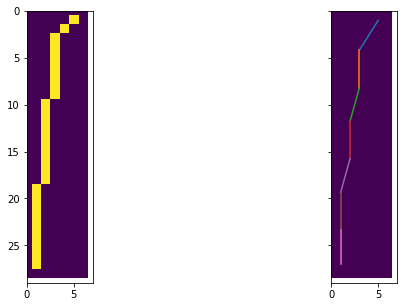

Length: 27.00, Waveiness: 0.2041 



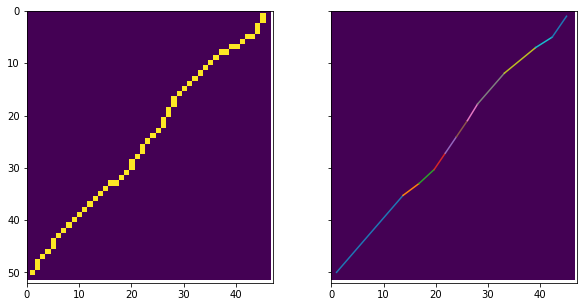

Length: 54.00, Waveiness: 0.2498 



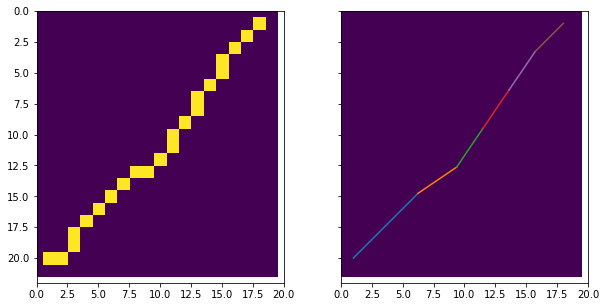

Length: 22.00, Waveiness: 0.2855 



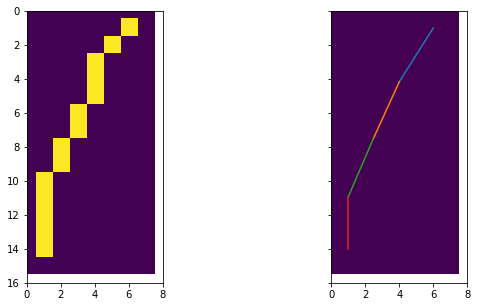

Length: 14.00, Waveiness: 0.3294 



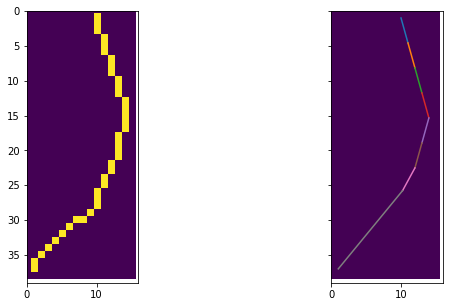

Length: 38.00, Waveiness: 0.3728 



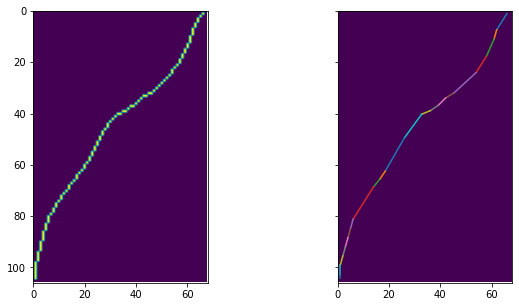

Length: 109.00, Waveiness: 0.2904 



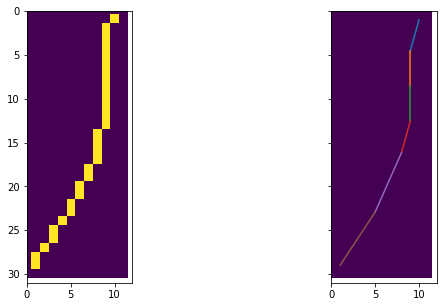

Length: 29.00, Waveiness: 0.2364 



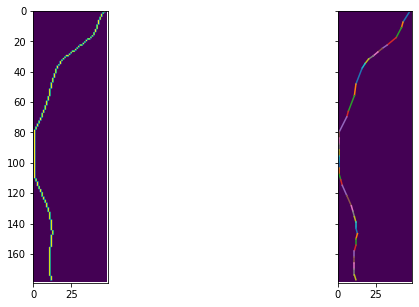

Length: 181.00, Waveiness: 0.2369 



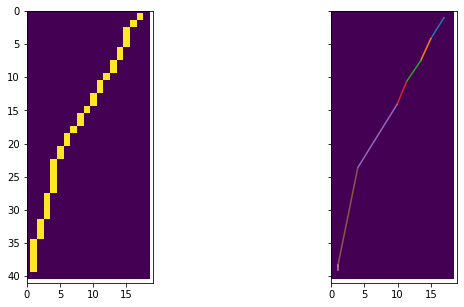

Length: 39.00, Waveiness: 0.3325 



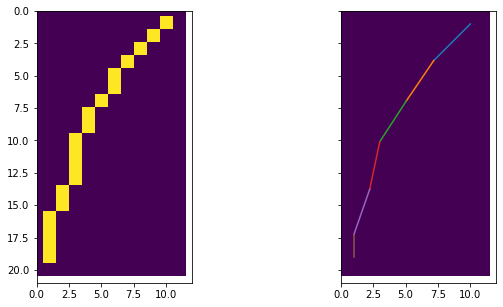

Length: 19.00, Waveiness: 0.2947 



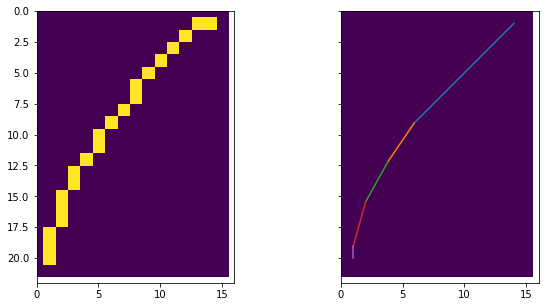

Length: 21.00, Waveiness: 0.3152 



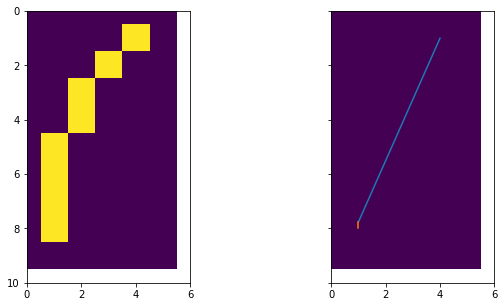

Length: 8.00, Waveiness: 0.2952 



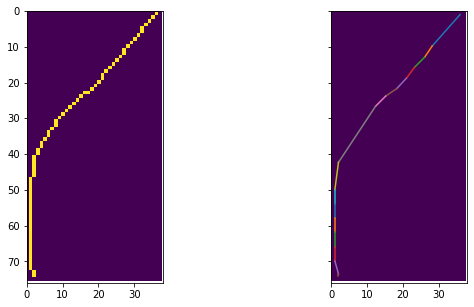

Length: 75.00, Waveiness: 0.1595 



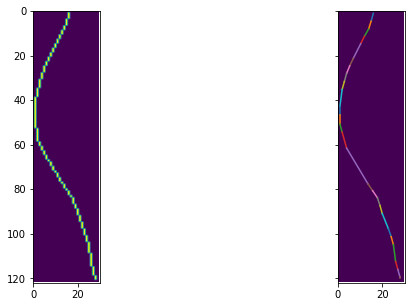

Length: 120.00, Waveiness: 0.3111 



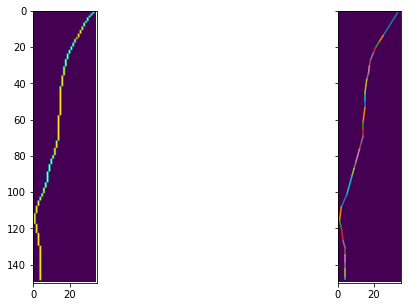

Length: 148.00, Waveiness: 0.2360 



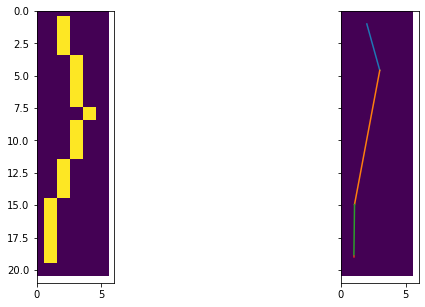

Length: 19.00, Waveiness: 0.3943 



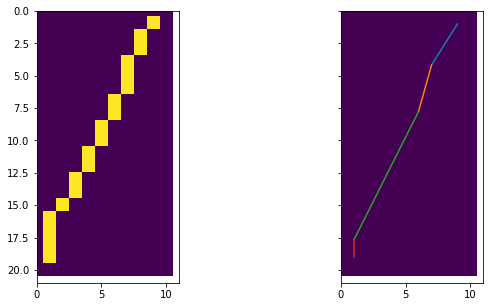

Length: 19.00, Waveiness: 0.3478 



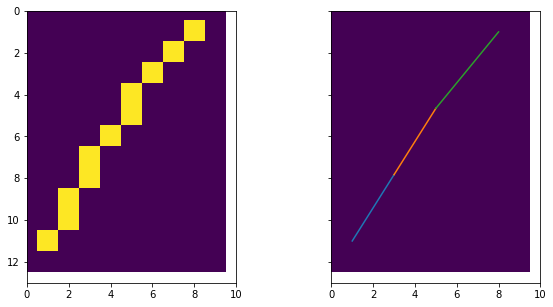

Length: 11.00, Waveiness: 0.2508 



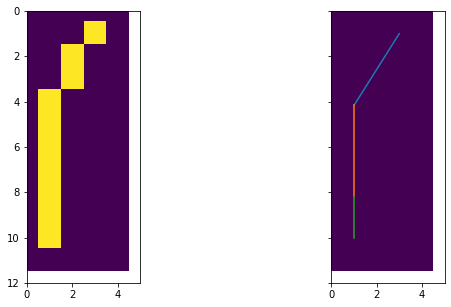

Length: 10.00, Waveiness: 0.2130 



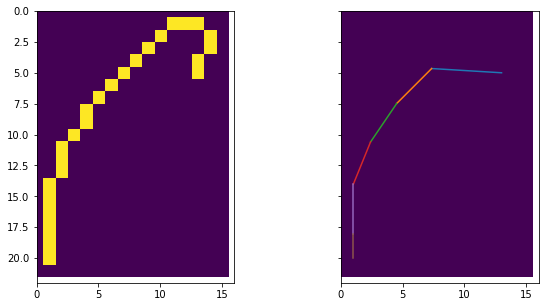

Length: 26.00, Waveiness: 0.5754 



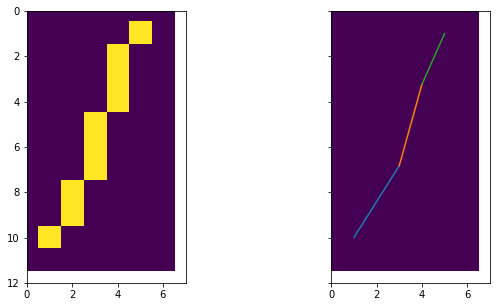

Length: 10.00, Waveiness: 0.3380 



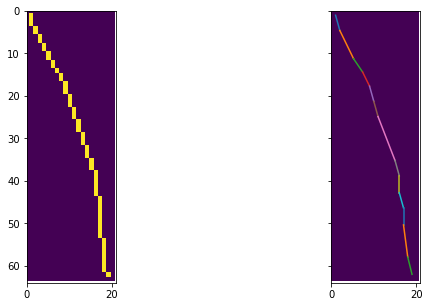

Length: 62.00, Waveiness: 0.2956 



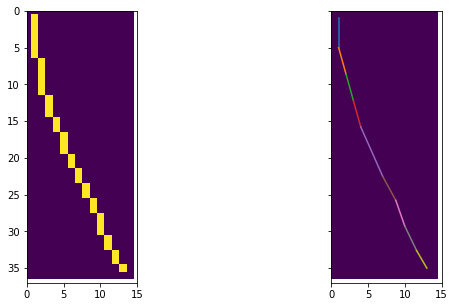

Length: 35.00, Waveiness: 0.3357 



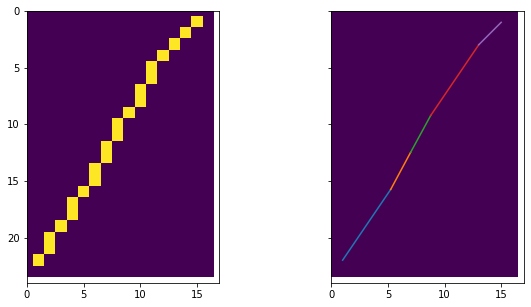

Length: 22.00, Waveiness: 0.2875 



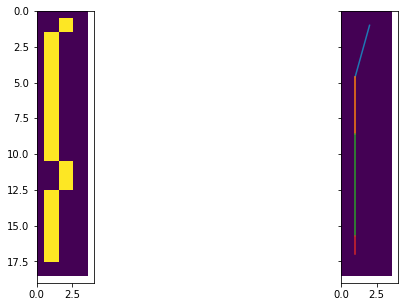

Length: 17.00, Waveiness: 0.3163 



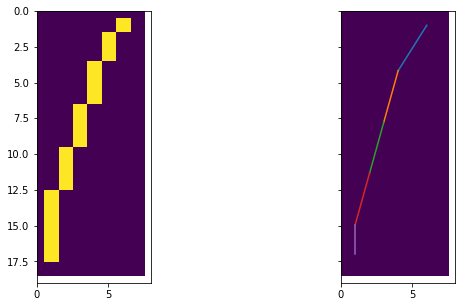

Length: 17.00, Waveiness: 0.3186 



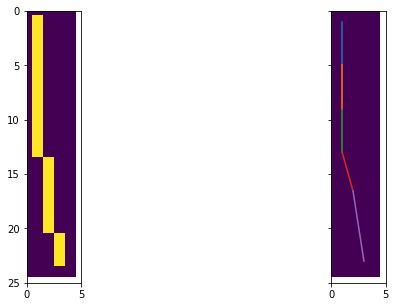

Length: 23.00, Waveiness: 0.1237 



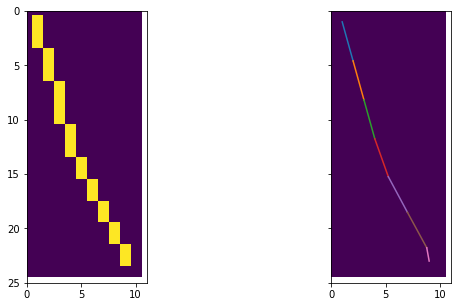

Length: 23.00, Waveiness: 0.3432 



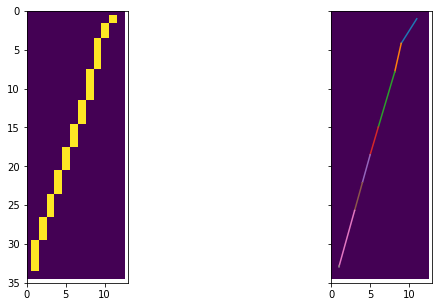

Length: 33.00, Waveiness: 0.3338 



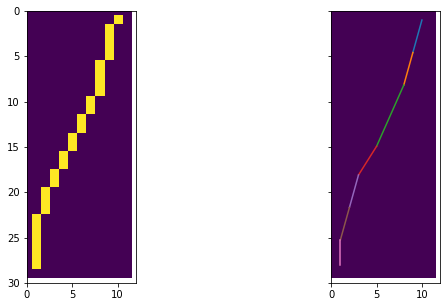

Length: 28.00, Waveiness: 0.3341 



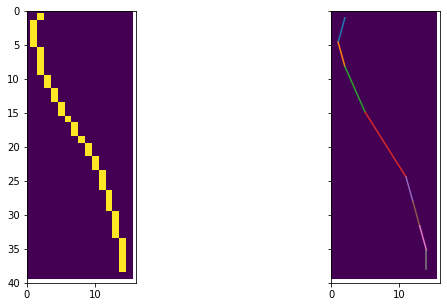

Length: 38.00, Waveiness: 0.3528 



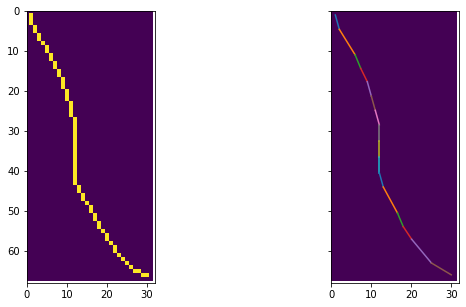

Length: 68.00, Waveiness: 0.2794 



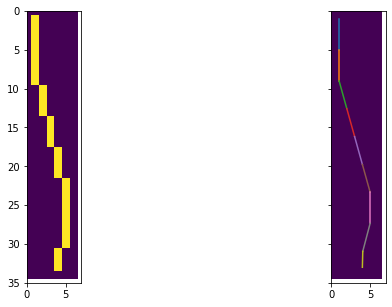

Length: 33.00, Waveiness: 0.2513 



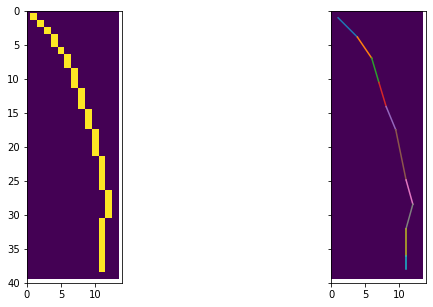

Length: 38.00, Waveiness: 0.3065 



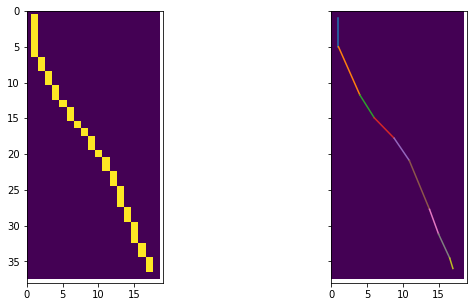

Length: 36.00, Waveiness: 0.3184 



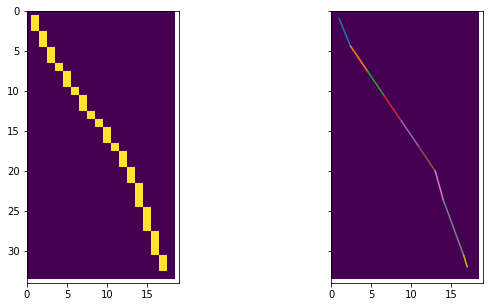

Length: 32.00, Waveiness: 0.3121 



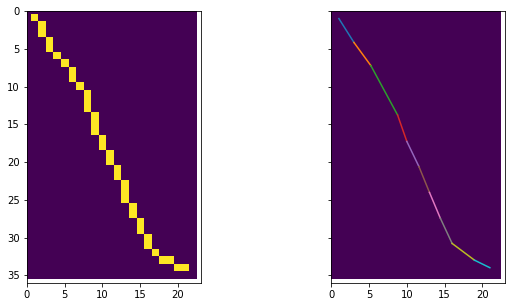

Length: 36.00, Waveiness: 0.3730 



In [14]:
centerline = centerline_res
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad( region.image, (1, 1) )
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length/seg_length))
    split_points = [int(i*seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
    if len(splitter) < 1: fragments = [shape_line]
    else: fragments = split(shape_line, splitter)
    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image* 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))
    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waveiness: {waviness:.4f} \n')